In [2]:
import concept_subspaces
import ssccd

import torch.cuda
from torch.nn import Sequential, Flatten

import numpy as np
import sklearn.decomposition

from general_utils import imagenet_utils, visualize_utils, data_utils

import matplotlib.pyplot as plt

Load a pretrained model. Any CNN/ ViT architecture with a linear classification head after pooling is possible.

In [3]:
model_arch = "resnet50"
# model_arch = "swin_s3_base_224"

model = imagenet_utils.get_pretrained_model(model_arch, use_timm=True)

model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()

Seperate model into feature extractor, avgpool and linear classifier layer

In [4]:
model = list(model.children())
model = [layer for layer in model if not type(layer) is Flatten]  # remove Flatten layers
if model_arch=="swin_s3_base_224":
    feature_model = Sequential(*model[:-1]) # no avgpool
else:
    feature_model = Sequential(*model[:-2])
    avgpool = model[-2]
linear_classifier = model[-1]

## (1) Concept Discovery

Load images of the poice van class from the ImageNet train set 

In [5]:
data_path = "/media/vielhaben/Data1/ImageNet-complete"
device = next(model[0].parameters()).device
n_batches = 6
batch_size = 64

class_map = imagenet_utils.get_class_map(data_path)
dict_description_to_class = imagenet_utils.get_dict_class_to_description(data_path)

c = "police van"
cid = dict_description_to_class[c]  # class id
cint = class_map[np.isin(class_map["class"],cid)]["classId"].values[0]   # class integer

loader = imagenet_utils.get_dataloader(data_path, [cid,], batch_size, train=True, shuffle=False)

# get feature maps
feature_maps, _, _, _= data_utils.load_features(feature_model, loader, n_batches, None, device, postprocess_features=False)
feature_maps = feature_maps.numpy()


Samples in the dataset: 1300


Extract feature vectors

In [6]:
mcd = ssccd.SSCCD(feature_maps)
mcd.get_feature_array(sample_ratio=0.75)

#### MCD-SSCCD and -kmeans (option 1)

MCD-SSCCD (option 1.1):

1. fit selfrepresentation

In [7]:
kmeans = False

# fit self-representation
mcd.fit_selfrepresentation(n_nonzero=-1, outlier_percentile=0.75, gamma=10.0, tau=1.0)
# save self-representation file
mcd.ssc.save_self_representation("./selfrepresentation.npz")


100%|██████████| 14112/14112 [06:06<00:00, 38.47it/s]


For MCD-kmeans (option 1.2)

1. no need to fit a selfrepresentation

In [ ]:
kmeans = True

2. Clustering and construction of concept bases

We determine the number of concept subspaces by requiring them to achieve a threshold on the completeness score:

In [8]:
completeness_threshold = 0.5

# To measure concept completeness, 
# we need the weight vector corresponding to the class under consideration from the linear classification layer of the model:
weight_vector = linear_classifier.weight.detach()[cint].cpu().numpy()

completeness = 0.0

for n_concepts in range(1, 20):
    # cluster
    mcd.cluster(n_concepts, kmeans=kmeans)
    
    # determine bases for concept subspaces
    mcd.conceptspace_bases(ver="FO", one_dim=False)
    bases = mcd.conceptBases

    concept_tester = concept_subspaces.TestConceptSubspaces(bases, assert_intersection=False)
    completeness, length_complement = concept_tester.concept_completeness(weight_vector)
    
    if completeness>=completeness_threshold:
        break

Optionally, concept bases can be orthogoalized

In [ ]:
concept_tester.orthogonalize_subspaces(weight_vector)

continue with (2) or choose

#### MCD-PCA/ ICE (option 2)

fit PCA

In [10]:
features = ssccd.SSCCD.map_to_array(maps=feature_maps, n_channel=feature_maps.shape[1])
# subsampling
features = data_utils.subsample_features(features, feature_subsample_ratio=0.8)
# scale to 0 mean
features = features - features.mean(axis=0, keepdims=True)
pca = sklearn.decomposition.PCA()
pca.fit(features)

PCA()

determine the number of PCA components by requiring them to achieve a threshold on the completeness score:

In [11]:
completeness_threshold = 0.5

# To measure concept completeness, 
# we need the weight vector corresponding to the class under consideration from the linear classification layer of the model:
weight_vector = linear_classifier.weight.detach()[cint].cpu().numpy()

completeness = 0.0

for n_concepts in range(1, 500):
    bases = list(pca.components_[:n_concepts,np.newaxis])

    concept_tester = concept_subspaces.TestConceptSubspaces(bases, assert_intersection=False)
    completeness, length_complement = concept_tester.concept_completeness(weight_vector)
    
    if completeness>=completeness_threshold:
        break

# (2) Concept relevance heatmaps and inherent interpretability

#### Global importance

In [9]:
global_importance = concept_tester.conceptspace_global_importance(weight_vector)
global_importance_bounds = concept_tester.conceptspace_global_importance_bounds(weight_vector)

global_importance, global_importance_bounds

(array([0.22298469, 0.519837  , 0.35039156, 0.4178602 , 0.86191377]),
 (0.016936256339717255, 1.5147684753642903))

#### Local importance

In [10]:
# load images and feature maps from test set
#test_batch_size = 50 # all imagenet test set samples 
loader = imagenet_utils.get_dataloader(data_path, [cid], 50, train=False, shuffle=False, ace_resize=False)

feature_maps, _, data, _= data_utils.load_features(feature_model, loader, 1, None, device, return_data=True, postprocess_features=False)
batch_size = feature_maps.shape[0]
n_channel =  feature_maps.shape[1]


Samples in the dataset: 50


In [11]:
if model_arch=="swin_s3_base_224":
    features_gap = feature_maps.view((batch_size, n_channel, -1)).cpu().numpy().mean(axis=-1)
else:
    features_gap = avgpool(feature_maps).cpu().squeeze().numpy()

local_importance = concept_tester.conceptspace_local_importance(weight_vector, features_gap)


50it [00:04, 12.06it/s]


# Visualize concepts

Compute feature-concept similarities

In [12]:
similarities = concept_tester.conceptspace_vector_similarities(feature_maps.numpy())

100%|██████████| 50/50 [03:09<00:00,  3.79s/it]


We focus on a random sample:

In [25]:
example_idx = 5

Compute concept relevance heatmap for this sample

In [26]:
features = ssccd.SSCCD.map_to_array(feature_maps[example_idx:example_idx+1].numpy(),  n_channel)
local_importance_map = concept_tester.conceptspace_local_importance(weight_vector, features)
local_importance_map = ssccd.SSCCD.array_to_map(local_importance_map, 1, n_concepts+1, feature_maps.shape[2:])

49it [00:03, 12.51it/s]


Plot the concepts in order of decreasing global relevance

In [17]:
concept_order = np.concatenate( [ (-1.0*global_importance[:-1]).argsort(), [len(global_importance)-1] ] )  # complement last


Visualize concept activation and relevance

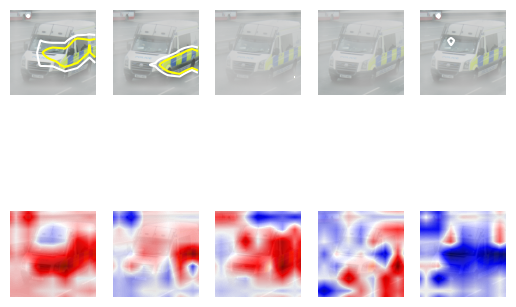

In [27]:
_, ax = plt.subplots(2, len(concept_order))

for i,c in enumerate(concept_order):
    # concept activation map
    visualize_utils.visualize_single_concept(similarities[example_idx,c], data[example_idx], ax[0,i], concept_expression=True, swin="swin" in model_arch)

    # local concept relevance
    visualize_utils.visualize_single_concept(local_importance_map[0,c], data[example_idx], ax[1,i], concept_expression=False, swin="swin" in model_arch)



To understand the meaning of the concepts, we visualize concept expression maps for prototype samples.

5 5 [1 3 2 0 4]


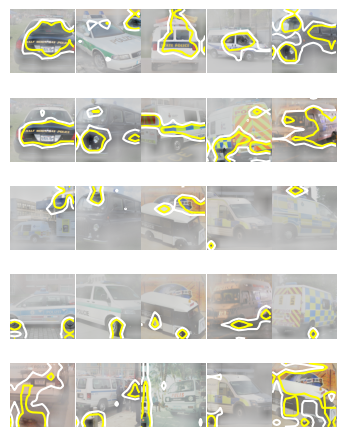

In [28]:
n_examples = 5
similarities_max = similarities.max(axis=(2,3))
example_idx = (-1.0*similarities_max).argsort(axis=0)[:n_examples]

concept_order = np.concatenate( [ (-1.0*global_importance[:-1]).argsort(), [len(global_importance)-1] ] )  # complement last
ax = visualize_utils.visualize_concepts(example_idx, similarities, data, concept_order, swin="swin" in model_arch)
